In [1]:
import pandas as pd
import numpy as np
from cataclop.ml.pipeline import factories

In [2]:
d = factories.Dataset.factory('default')
d.load(force=True)
d.players.head()

age  earnings  final_odds  final_odds_ref  handicap_distance  \
race_id id                                                                 
1       2     5  15748400         5.1             5.8             2100.0   
        3     4  19096000        11.8            12.4             2100.0   
        4     4   7796500        29.0            21.5             2100.0   
        5     5  18067000        17.7            14.5             2100.0   
        6     5  20673000        63.3            36.1             2100.0   

            handicap_weight  herder_id  horse_id         imported_at_player  \
race_id id                                                                    
1       2               NaN        NaN         2 2018-05-23 15:29:04.165302   
        3               NaN        2.0         3 2018-05-23 15:29:03.962649   
        4               NaN        3.0         4 2018-05-23 15:29:03.992521   
        5               NaN        4.0         5 2018-05-23 15:29:04.025540   
        6               NaN        5.0         6 2018-05-23 15:29:04.055841   

            is_first_timer    ...                start_at  \
race_id id                    ...                           
1       2            False    ...     2017-10-20 19:43:00   
        3            False    ...     2017-10-20 19:43:00   
        4            False    ...     2017-10-20 19:43:00   
        5            False    ...     2017-10-20 19:43:00   
        6            False    ...     2017-10-20 19:43:00   

                    sub_category        date  hippodrome_id  \
race_id id                                                    
1       2   EUROPEENNE_AUTOSTART  2017-10-20              1   
        3   EUROPEENNE_AUTOSTART  2017-10-20              1   
        4   EUROPEENNE_AUTOSTART  2017-10-20              1   
        5   EUROPEENNE_AUTOSTART  2017-10-20              1   
        6   EUROPEENNE_AUTOSTART  2017-10-20              1   

                  imported_at_session  num_session  code  country  \
race_id id                                                          
1       2  2018-05-23 15:29:03.883002            1   VIN      FRA   
        3  2018-05-23 15:29:03.883002            1   VIN      FRA   
        4  2018-05-23 15:29:03.883002            1   VIN      FRA   
        5  2018-05-23 15:29:03.883002            1   VIN      FRA   
        6  2018-05-23 15:29:03.883002            1   VIN      FRA   

                    imported_at_hippo       name  
race_id id                                        
1       2  2018-05-21 14:53:00.375766  VINCENNES  
        3  2018-05-21 14:53:00.375766  VINCENNES  
        4  2018-05-21 14:53:00.375766  VINCENNES  
        5  2018-05-21 14:53:00.375766  VINCENNES  
        6  2018-05-21 14:53:00.375766  VINCENNES  

[5 rows x 49 columns]

In [3]:
df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight'
               ]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='inner')

for f in agg_features:
    df['{}_r'.format(f)] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(1000)

odds = pd.DataFrame(columns=['odds_{:d}'.format(i) for i in range(20)], index=df.index)

races = df.groupby('race_id')

for (id, race) in races:
    odds_sorted = sorted(race['final_odds_ref'].values)
    odds.loc[race.index, ['odds_{:d}'.format(i) for i, v in enumerate(odds_sorted)]] = odds_sorted

df = pd.concat([df,odds], axis=1)

df[['odds_{:d}'.format(i) for i in range(20)]] = df[['odds_{:d}'.format(i) for i in range(20)]].fillna(1000.0)

df['speed'] = (df['distance'] / df['time']).fillna(1000)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(0.)

df = df.sort_index()
df_orig = df.copy()

In [65]:
df = df_orig[df_orig['category']=='ATTELE'].copy()
df = df.sort_index()

In [84]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df.index.droplevel(1).values

group_kfold = GroupKFold(n_splits=3)

features = agg_features

features = features + ['declared_player_count', 'speed']

features = features + ['odds_{:d}'.format(i) for i in range(20)]

df['pred_win'] = 0.0
for i in range(6):
    df['pred_{}'.format(i+1)] = 0.0

df['target'] = df['position'].copy()
df.loc[df['target'] > 6, 'target'] = 6
df['target'].fillna(6, inplace=True)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

for train_index, test_index in splits:

    X_train = df[features].iloc[train_index].copy()
    y_train = df['target'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
    y_train = df['target'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]


    X_test = df[features].iloc[test_index].copy()
    y_test = df['target'].iloc[test_index]

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    
    #scaler = StandardScaler()
    #scaler.fit(X_train)

    #X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)

    idx = df.iloc[test_index].index

    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, y_train.values)

    p = clf.predict_proba(X_test)
    df.loc[idx, 'pred_win'] = p[:, list(clf.classes_).index(1)]
        
    for i in range(6):
        df.loc[idx, 'pred_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    

In [92]:
df[['category', 'speed', 'victory_earnings_r', 'num', 'position', 'final_odds_ref', 'pred_win', 'pred_1', 'pred_2', 'pred_3']][:20]

category        speed  victory_earnings_r  num  position  \
race_id id                                                              
1       2      ATTELE     0.013444        1.574840e+07    2       2.0   
        3      ATTELE     0.013389        1.909600e+07    3       5.0   
        4      ATTELE  1000.000000        7.796496e+06    4       NaN   
        5      ATTELE     0.013378        1.806700e+07    5       6.0   
        6      ATTELE     0.013273        2.067300e+07    6       7.0   
        7      ATTELE     0.013472        1.634700e+07    7       NaN   
        8      ATTELE     0.013412        1.491420e+07    8       4.0   
        5154   ATTELE     0.013483        1.981000e+07    1       1.0   
29      169    ATTELE  1000.000000        1.542497e+07    2       NaN   
        170    ATTELE     0.012977        1.487097e+07    3      12.0   
        171    ATTELE     0.013229        1.535097e+07    4       2.0   
        172    ATTELE     0.013179        1.539997e+07    5       5.0   
        173    ATTELE     0.013118        1.549497e+07    6       8.0   
        174    ATTELE     0.013293        1.525897e+07    7       1.0   
        175    ATTELE     0.013093        1.481797e+07    8      11.0   
        176    ATTELE     0.013103        1.462497e+07    9       9.0   
        177    ATTELE  1000.000000        1.482897e+07   10       NaN   
        178    ATTELE     0.013095        1.434597e+07   11      10.0   
        179    ATTELE     0.013180        1.434497e+07   12       4.0   
        180    ATTELE     0.013164        1.446597e+07   13       7.0   

              final_odds_ref  pred_win  pred_1  pred_2  pred_3  
race_id id                                                      
1       2                5.8      0.18    0.18    0.27    0.07  
        3               12.4      0.17    0.17    0.26    0.07  
        4               21.5      0.08    0.08    0.13    0.06  
        5               14.5      0.15    0.15    0.33    0.06  
        6               36.1      0.12    0.12    0.36    0.04  
        7               11.8      0.14    0.14    0.21    0.12  
        8               48.7      0.22    0.22    0.17    0.13  
        5154             1.6      0.12    0.12    0.25    0.20  
29      169              3.1      0.10    0.10    0.03    0.03  
        170             68.6      0.11    0.11    0.11    0.08  
        171             25.2      0.18    0.18    0.09    0.05  
        172             16.4      0.10    0.10    0.06    0.06  
        173              4.0      0.12    0.12    0.15    0.12  
        174              7.1      0.18    0.18    0.11    0.09  
        175             84.2      0.15    0.15    0.11    0.07  
        176             16.3      0.09    0.09    0.04    0.10  
        177             13.0      0.04    0.04    0.05    0.04  
        178             71.5      0.10    0.10    0.10    0.07  
        179             27.1      0.18    0.18    0.10    0.08  
        180             51.1      0.14    0.14    0.08    0.08

In [93]:
fi = pd.Series(clf.feature_importances_, index=features+preprocessing.get_dummy_features(dummies))
print(fi.sort_values(ascending=False)[0:10])


speed                   0.215746
victory_earnings_r      0.128234
race_count_r            0.091365
placed_3_count_r        0.068978
victory_count_r         0.067244
prev_year_earnings_r    0.064129
placed_2_count_r        0.061109
odds_0                  0.025935
odds_2                  0.024070
odds_3                  0.022862
dtype: float64


In [89]:

df['pred_add'] = df['pred_1'] - df['pred_6']

races = df.groupby('race_id')

bets = []

for (id, race) in races:
    
    bet = 1
    
    r = race.sort_values(by='pred_add', ascending=False)
    
    r = r[(r['final_odds_ref']<20.) & (r['final_odds_ref'] > 1)]
    
    if len(r) == 0:
        continue
    
    player = r.iloc[0]
    
    profit = player['winner_dividend']/100.0 * bet - bet
    
    bets.append( (id, player['start_at'], bet, player['final_odds'], player['pred_win'], player['num'], profit) )
    
bets = pd.DataFrame(bets, columns=['id', 'date', 'bet', 'odds', 'pred', 'num', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['stash'] = bets['profit'].cumsum()


,id,date,bet,odds,pred,num,profit,stash
date,,,,,,,,
2017-10-01 16:15:00,61,2017-10-01 16:15:00,1,6.3,0.17,2,-1.0,-1.0
2017-10-02 13:47:00,62,2017-10-02 13:47:00,1,10.5,0.19,13,10.9,9.9
2017-10-02 16:58:00,68,2017-10-02 16:58:00,1,1.8,0.28,6,-1.0,8.9
2017-10-02 17:58:00,91,2017-10-02 17:58:00,1,6.2,0.24,4,-1.0,7.9
2017-10-02 18:28:00,92,2017-10-02 18:28:00,1,7.2,0.15,16,-1.0,6.9
2017-10-02 18:58:00,93,2017-10-02 18:58:00,1,45.4,0.16,12,-1.0,5.9
2017-10-02 19:28:00,94,2017-10-02 19:28:00,1,2.2,0.19,4,-1.0,4.9
2017-10-04 11:10:00,150,2017-10-04 11:10:00,1,8.4,0.29,6,4.0,8.9
2017-10-04 12:40:00,153,2017-10-04 12:40:00,1,5.4,0.16,12,-1.0,7.9


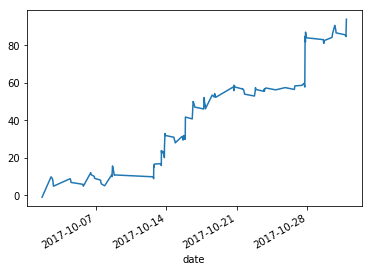

In [91]:
import matplotlib
%matplotlib inline
bets['stash'].plot()

bets[0:10]